# Using LLMs as High-Level Planners for Multi-Agent Coordination

This notebook provides a step-by-step guide to customizing and interacting with the RL environment.

## For Submission
1. Fill in your code in `submit.py`. 
   - Add your code *only* in the TODO sections marked by the '#' delimiter lines. Do not modify any other parts of the script.
   - You should implement any helper functions/classes in a separate `helper.py` file and import them in `submit.py`.
1. Submit `out.log` and `results.csv` generated by the `submit.py` script.


In [110]:
# Import necessary libraries and modules
import gymnasium as gym
import multigrid.envs
import matplotlib.pyplot as plt
from agents import AgentCollection
from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Initial Plan Generation

An intial plan can be generated by the `initial_planner` by invoking it with the grid size and number of agents available.

In [111]:
import configparser

config = configparser.ConfigParser()
config.read("env_config.ini")

environments = {}
for section in config.sections():
    M = config.getint(section, "number_of_agents")
    N = config.getint(section, "grid_size")
    goals = eval(config.get(section, "goals"))
    mission_statement = eval(config.get(section, "mission_statement"))
    # num_trials = config.getint(section, "number_of_trials")
    environments[section] = {
        "N": N,
        "M": M,
        "goals": goals,
        "mission_statement": mission_statement,
    }

In [112]:
from models import claude_llm as llm
from planner import PromptPlanner

In [113]:
selected_env = environments["env.SPATIAL_1_1"]
env = multigrid.envs.EmptyEnvV2(
    size=selected_env["N"],  # Specify the size of the grid, N
    agents=selected_env["M"],  # Specify number of agents, M
    goals=selected_env["goals"],  # Specify target positions for agents
    mission_space=selected_env["mission_statement"],
    render_mode="rgb_array",
    hidden_goals=True,
    # max_steps=50, # For debugging, you can set a maximum number of steps
)

# Always reset the environment before starting
observations, infos = env.reset()

agents = AgentCollection(num=selected_env["M"])

planner = PromptPlanner(llm=llm, grid_size=N, observations=observations, infos=infos)

# Providing the agents with high-level instructions
mission = observations[0]["mission"]
plan = planner.initial_plan()
print(plan)

# Search Plan for 5 Targets in 60×60 Grid

## Mission Analysis
- Grid size: 60×60
- Agents: 5
- Targets: 5
- All targets are confined to the top-left 6×6 region (coordinates x=1-6, y=1-6)
- This is a highly localized search area (36 cells) with enough agents (5) to efficiently divide the work

## Strategy Overview
Since all targets are confined to a small 6×6 region and we have 5 agents, we'll focus exclusively on this region rather than exploring the entire 60×60 grid. We'll divide the 6×6 region among our 5 agents to ensure complete coverage with minimal redundancy.

## Region Partitioning
I'll divide the 6×6 region into 5 approximately equal sections:
- Agent 1: Rows 1-2, Columns 1-3 (6 cells)
- Agent 2: Rows 1-2, Columns 4-6 (6 cells)
- Agent 3: Rows 3-4, Columns 1-3 (6 cells)
- Agent 4: Rows 3-4, Columns 4-6 (6 cells)
- Agent 5: Rows 5-6, Columns 1-6 (12 cells)

## Movement Plan

### Phase 1: Initial Deployment (All agents start at (1,1))
- Agent 1: Already at starting position of

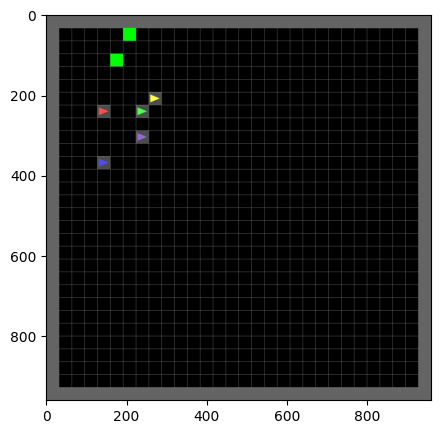

-17.06039460035691


In [114]:
for agent, actions in plan.items():
    for action in actions:
        agents.tell({agent: action.serialize()})

while not agents.all_idle() and not env.unwrapped.is_done():
    # Obtain the low-level action for current time step for all agents
    a = agents.act()

    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(a)
    print(observations)
    print(a, rewards, terminations, truncations)

    plan = planner.replan(
        agents, observations, rewards, terminations, truncations, infos
    )
    for agent, actions in plan.items():
        for action in actions:
            agents.tell({agent: action.serialize()})

    # Render the environment
    clear_output(wait=True)
    img = env.render()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()

print(infos["total_reward"])
env.close()